In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [14]:
#Wrappers
def calibrateCamera(img,img_points,obj_points):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return (mtx,dist)

def undistImage(img,mtx,dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def get_binary(undist,ksize,mag_thresh,dir_thresh,col_thresh,test=False):
    
    if not test:
        hls = cv2.cvtColor(undist,cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        gray = cv2.cvtColor(undist,cv2.COLOR_RGB2GRAY)
    
    else:
        gray = undist
        s_channel = undist
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)

    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)    
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)

    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobelx))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    dir_grad = np.arctan2(abs_sobely,abs_sobelx)

    gradx = np.zeros_like(gray)
    gradx[(scaled_sobelx>=mag_thresh[0])&(scaled_sobelx<=mag_thresh[1])] = 1

    grady = np.zeros_like(gray)
    grady[(scaled_sobely>=mag_thresh[0])&(scaled_sobely<=mag_thresh[1])] = 1

    dir_binary = np.zeros_like(gray)
    dir_binary[(dir_grad>dir_thresh[0])&(dir_grad<=dir_thresh[1])] = 1

    mag_binary = np.zeros_like(gray)
    mag_binary[(scaled_sobel>=mag_thresh[0])&(scaled_sobel<=mag_thresh[1])] = 1

    col_binary = np.zeros_like(s_channel)
    col_binary[(s_channel>col_thresh[0])&(s_channel<=col_thresh[1])] = 1
    
    combined_binary = np.zeros_like(gradx)
    combined_binary[((mag_binary == 1)&((dir_binary == 1)))| (col_binary == 1)] = 1
    #combined_binary[(gradx == 1)| (col_binary == 1)] = 1
    
    if not test:
        return combined_binary
    return [combined_binary,gradx,grady,dir_binary,mag_binary,col_binary]
    

def warp(img,warp=True):    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([(260,680),(545,485),(745,485),(1060,680)])
    #src = np.float32([(260,680),(568,470),(717,470),(1045,680)])[568,470]
    dst = np.float32([(300,720),(300,0),(900,0),(900,720)])
    
    if warp:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

def fit_lines(binary_warped,last_left_fit=[],last_right_fit=[]):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    if not (len(lefty) and len(leftx) and len(righty) and len(rightx)):
        left_fit = last_left_fit
        right_fit = last_right_fit
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Compute curve radius    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Now our radius of curvature is in meters
    avg_radius = np.mean([left_curverad, right_curverad])
    
    # Compute car position
    pos_car = binary_warped.shape[1] / 2
    pos_lane = (left_fitx[0] + right_fitx[0]) / 2
    car_offset = (pos_lane-pos_car)*xm_per_pix
    
    return out_img, avg_radius, car_offset, left_fitx, right_fitx, ploty

def addWeighted(org, lines,left_fitx,right_fitx,ploty):
    color_warp = np.zeros_like(lines).astype(np.uint8)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    unwarp = warp(color_warp,warp=False)
    
    return [cv2.addWeighted(org, 1, unwarp, 0.3, 0),color_warp]

def plot_images(img,title,gray=True):
    if gray:
        plt.figure(figsize=(15,10))
        plt.subplot(121).imshow(img[0], cmap='gray')
        plt.title(title[0])
        plt.subplot(122).imshow(img[1], cmap='gray')
        plt.title(title[1])
    else:
        plt.figure(figsize=(15,10))
        plt.subplot(121).imshow(img[0])
        plt.title(title[0])
        plt.subplot(122).imshow(img[1])
        plt.title(title[1])
    

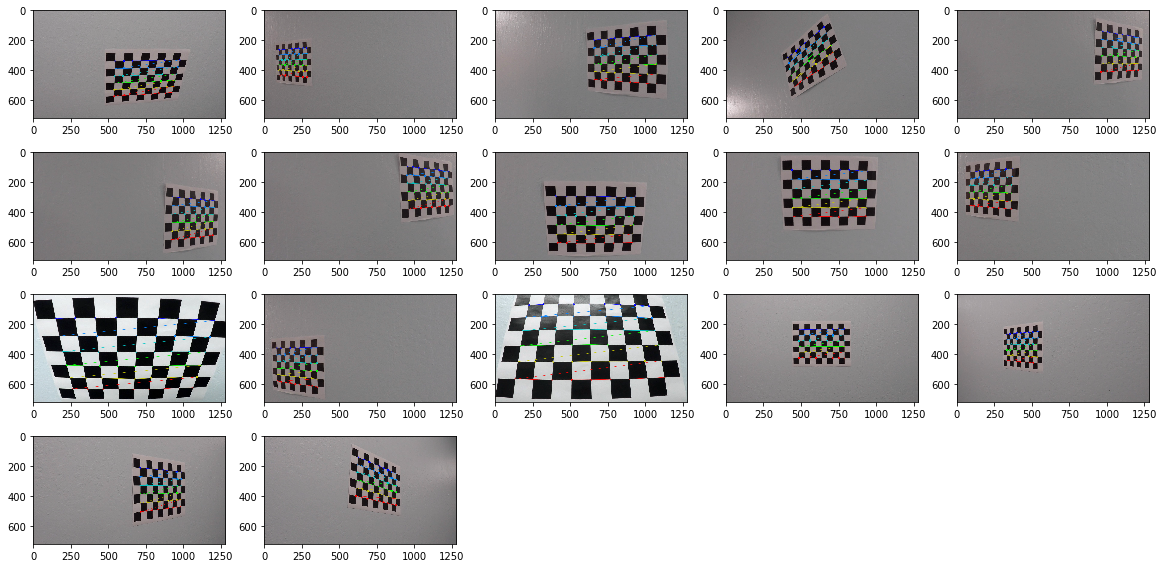

In [4]:
#List of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
objpoints = []
imgpoints = []

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

j=0
plt.figure(figsize=(20,10))
for i in images:
    img = cv2.imread(i)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points
    if ret == True:
        j+=1
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.subplot(4,5,j)
        plt.imshow(img)
        
# Camera calibration
test_image = cv2.imread('camera_cal/calibration2.jpg')
test_image = cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
mtx,dist = calibrateCamera(test_image,imgpoints,objpoints)

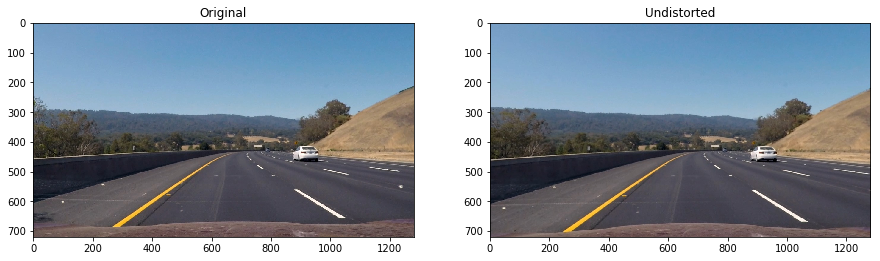

In [5]:
#Distortion correction
test1 = cv2.cvtColor(cv2.imread('test_images/test3.jpg'),cv2.COLOR_BGR2RGB)
undist = undistImage(test1,mtx,dist)

plot_images((test1,undist),('Original','Undistorted'),gray=False)

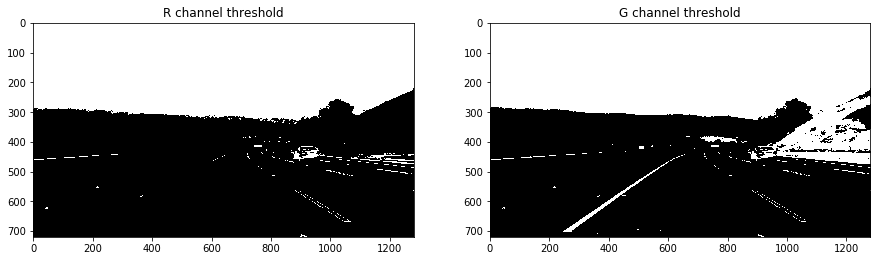

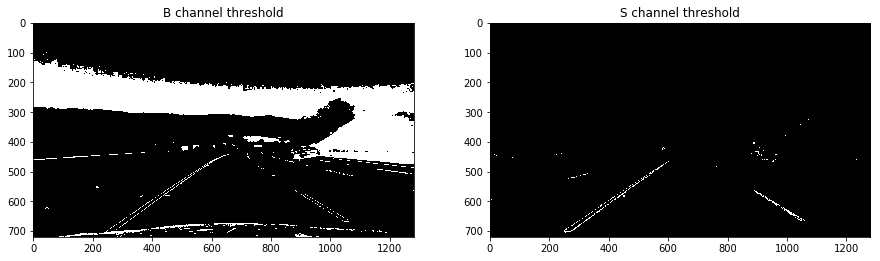

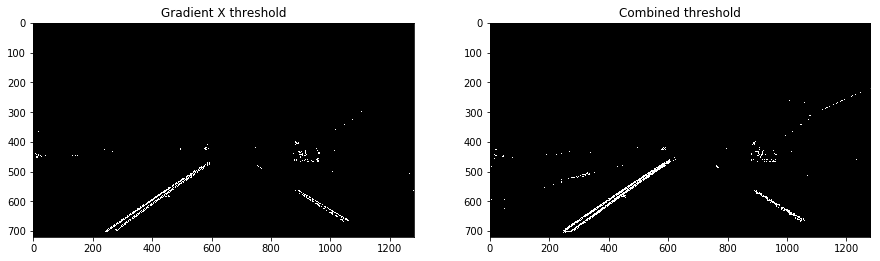

In [6]:
#Gradient and color threshold
hls = cv2.cvtColor(undist,cv2.COLOR_BGR2HLS)
rgb = cv2.cvtColor(undist,cv2.COLOR_BGR2RGB)

s = hls[:,:,2]
r = rgb[:,:,0]
g = rgb[:,:,1]
b = rgb[:,:,2]

binaries = [get_binary(i,5,(40,100),(0.7, 1.2),(130,225),test=True) for i in [r,g,b,s]]

plot_images((binaries[0][5],binaries[1][5]),('R channel threshold','G channel threshold'))
plot_images((binaries[2][5],binaries[3][5]),('B channel threshold','S channel threshold'))
plot_images((binaries[3][1],binaries[3][0]),('Gradient X threshold','Combined threshold'))

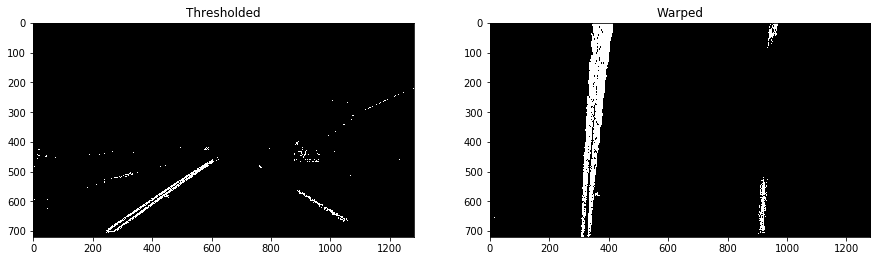

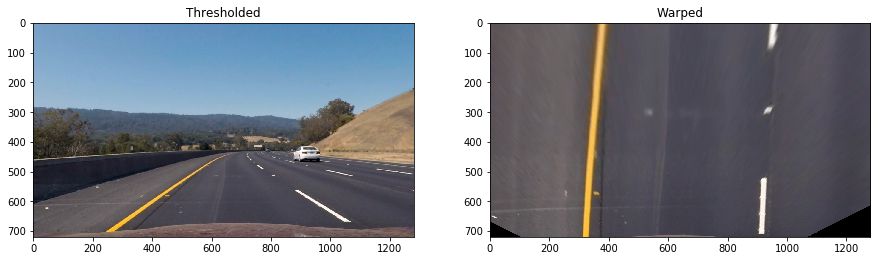

In [7]:
# Unwarping image
warped = warp(binaries[3][0])
warped_clr = warp(undist)

plot_images((binaries[3][0],warped),('Thresholded','Warped'))
plot_images((undist,warped_clr),('Thresholded','Warped'),gray=False)

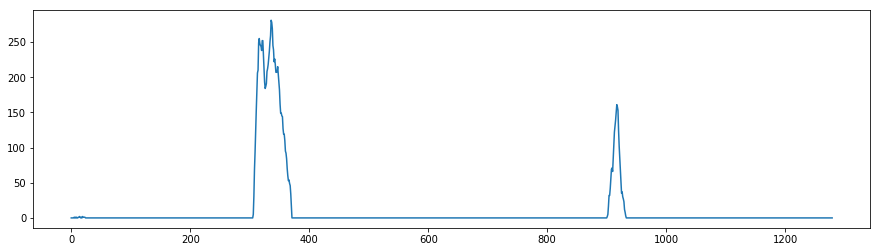

In [8]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.figure(figsize=(15,4))
plt.plot(histogram)

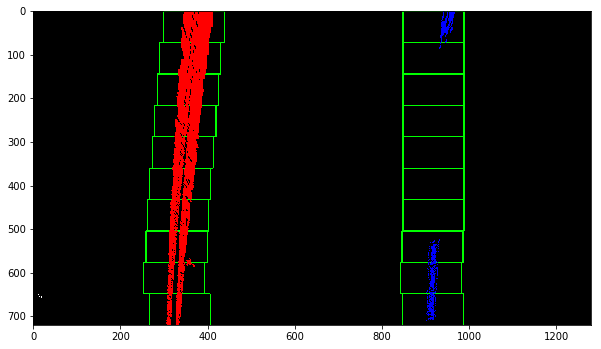

In [15]:
lines, meters, offset, left_fitx, right_fitx, ploty = fit_lines(warped)
plt.figure(figsize=(10,6))
plt.imshow(lines)

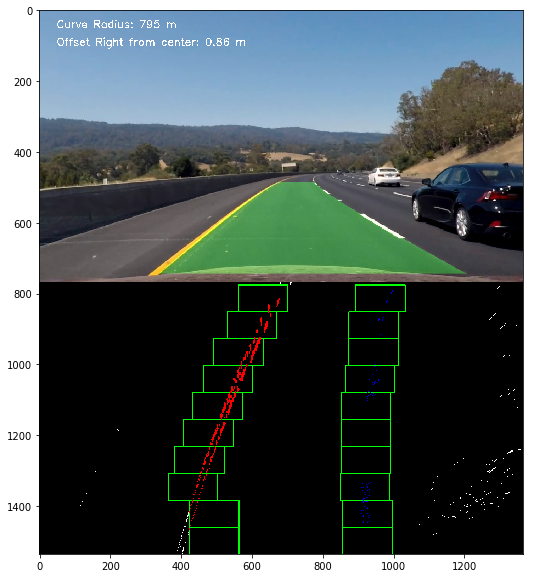

In [24]:
def process_image(img):

    undist = undistImage(img,mtx,dist)
    binary = get_binary(undist,3,(60,110),(0.9, 1.1),(190,200))
    warped = warp(binary)
    
    global last_l_fit
    global last_r_fit
    global l_fit_buffer
    global r_fit_buffer
    global lines_buffer
    
    if last_l_fit is None:
        last_l_fit=[]
        last_r_fit=[]
    
    lines, curve_m, offset, left_fit, right_fit, ploty  = fit_lines(warped,last_l_fit,last_r_fit)
    last_l_fit,last_r_fit = left_fit, right_fit

    if lines_buffer is None:
        lines_buffer = warped

    ret_val = cv2.matchShapes(lines_buffer, warped, 1, 0.0)

    if ret_val < 20:
        lines_buffer = warped

        if l_fit_buffer is None:
            l_fit_buffer = np.array([left_fit])

        if r_fit_buffer is None:
            r_fit_buffer = np.array([right_fit])

        l_fit_buffer = np.append(l_fit_buffer, [left_fit], axis=0)[-filter_size:]
        r_fit_buffer = np.append(r_fit_buffer, [right_fit], axis=0)[-filter_size:]

    l_fit_mean = np.mean(l_fit_buffer, axis=0)
    r_fit_mean = np.mean(r_fit_buffer, axis=0)

    weighted,cwarp = addWeighted(undist, lines, l_fit_mean, r_fit_mean, ploty)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Curve Radius: {:.0f} m".format(curve_m)
    cv2.putText(weighted, text, (50,50), font, 1, (255,255,255), 2)
    text = "Offset Right from center: {:.2f} m".format(offset)
    cv2.putText(weighted, text, (50,100), font, 1, (255,255,255), 2)
    
    return np.vstack((weighted, lines))
    #return output

filter_size = 30
last_l_fit=None
last_r_fit=None
lines_buffer = None
l_fit_buffer = None
r_fit_buffer = None

img = cv2.cvtColor(cv2.imread('test_images/test_my.jpg'),cv2.COLOR_BGR2RGB)
r = process_image(img)
plt.figure(figsize=(15,10))
plt.imshow(r)
plt.show()

In [25]:
lines_buffer = None
l_fit_buffer = None
r_fit_buffer = None

project_video_output = './output_videos/project_video_f10.mp4'
clip1 = VideoFileClip("./project_video.mp4").subclip(27,45)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video_f10.mp4
[MoviePy] Writing video ./output_videos/project_video_f10.mp4


100%|███████████████████████████████████████████████████████████████████████████████▊| 450/451 [01:54<00:00,  4.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video_f10.mp4 

Wall time: 1min 57s


In [26]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))